# Train consumption
### Road to undestanding and graphing by NEM0215

## Sources
> https://www.movable-type.co.uk/scripts/latlong.html

> https://boulter.com/gps/distance/?from=49.97212553+17.860912499&to=49.972125524+17.860912502&units=k

> https://pressbooks.bccampus.ca/physics0312chooge/chapter/2-4-acceleration/

> https://www.quora.com/How-do-you-find-final-velocity-from-acceleration-and-distance

> https://www.quora.com/How-do-I-calculate-the-final-velocity-based-on-distance-and-acceleration-with-the-initial-velocity-being-0-What-is-the-formula

> https://www.real-world-physics-problems.com/work-and-energy.html

> https://energyeducation.ca/encyclopedia/Energy_vs_power

> https://www.khanacademy.org/science/in-in-class11th-physics/in-in-class11th-physics-work-energy-and-power/in-in-class11-work-energy-theorem/a/work-energy-theorem-ap1

> https://en.wikipedia.org/wiki/Equations_of_motion#Uniform_acceleration

> https://www.shorttutorials.com/how-to-calculate-power/given-mass-acceleration-velocity.html

> https://mdpi-res.com/d_attachment/energies/energies-15-04256/article_deploy/energies-15-04256-v2.pdf?version=1654851864

## Imports

In [1]:
import json
import math
import matplotlib.pyplot as plt

## Constants

In [2]:
G_TO_MS2 = 9.80665
TRAIN_ACC_G = 0.1
TRAIN_ACC_MS2 = TRAIN_ACC_G * G_TO_MS2
TRAIN_DEC_G = 0.12
TRAIN_DEC_MS2 = TRAIN_DEC_G * G_TO_MS2

## Functions

In [3]:
def parse_points_from_geojson(geojson_raw):
    geojson = json.loads(geojson_raw)
    return geojson["coordinates"]

In [4]:
# https://www.movable-type.co.uk/scripts/latlong.html
def calc_distance_two_points(point_a, point_b):
    R = 6371e3 # meters
    φ1 = point_a[1] * math.pi/180 # φ, λ in radians
    φ2 = point_b[1] * math.pi/180
    Δφ = (point_b[1]-point_a[1]) * math.pi/180
    Δλ = (point_b[0]-point_a[0]) * math.pi/180
    
    a = math.sin(Δφ/2) * math.sin(Δφ/2) + math.cos(φ1) * math.cos(φ2) * math.sin(Δλ/2) * math.sin(Δλ/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    
    return R * c # in meters

In [5]:
def calc_kinetic_energy(mass, velocity):
    return (mass*velocity**2)/2

In [6]:
def calc_velocity(acceleration, distance, init_velocity=0):
    return math.sqrt(init_velocity**2 + 2*acceleration*distance)

def calc_distance(acceleration, velocity, init_velocity=0):
    return (velocity**2-init_velocity**2)/(2*acceleration)

345


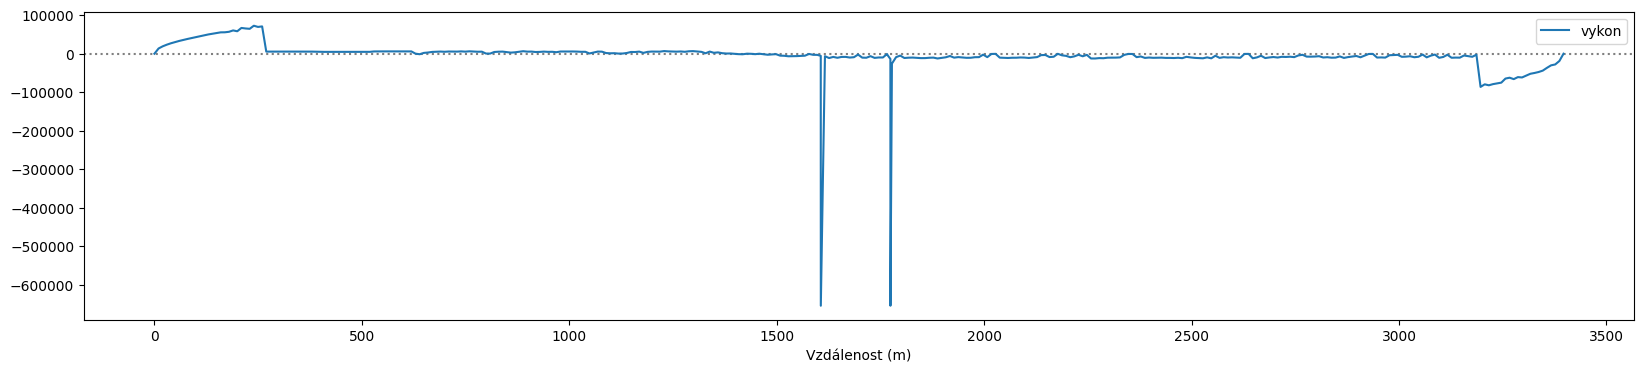

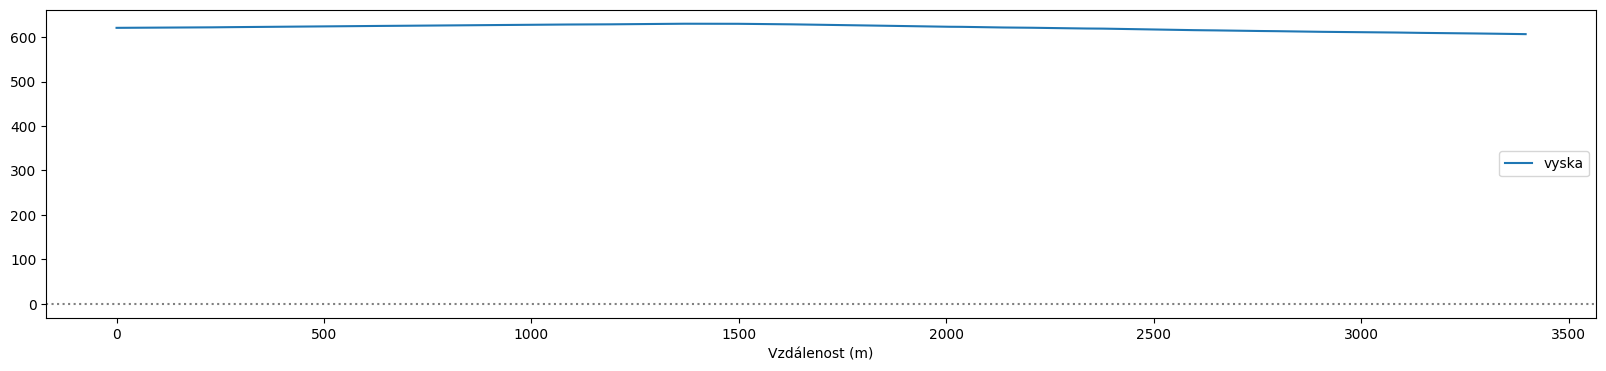

In [100]:
def get_elevation_slope_sin(point_a, point_b, dist):
    elevation_delta = point_b[2] - point_a[2] # NOTE: incline specific
    slope_distance = math.sqrt(elevation_delta**2 + dist**2)
    # print(slope_distance)
    return elevation_delta/slope_distance, slope_distance

def get_deceleration(points, max_velocity, decimal_places=2):
    dist = 0
    end_velocity = [0]
    for i in range(len(points)-1,0,-1):
        dist_to_next = dist + calc_distance_two_points(points[i], points[i-1])
        while True:
            # dist += 1/10**decimal_places
            dist = dist_to_next # NOTE: Normalization disabled
            velocity = calc_velocity(TRAIN_DEC_MS2, dist)
            if velocity >= max_velocity:
                break
            end_velocity.append(velocity)
            break
    return end_velocity

def get_acceleration(points, max_velocity, decimal_places=2):   
    dist_values = [0]
    velocity_values = [0]
    acceleration_values = [0]
    angle_sin_values = [0]
    
    dist = 0
    velocity_reached = False
    for i in range(len(points)-1):
        immediate_distance = calc_distance_two_points(points[i], points[i+1])
        angle_sin, slope_distance = get_elevation_slope_sin(points[i], points[i+1], immediate_distance)
        angle_sin_values.append(angle_sin)
        dist_to_next = dist + slope_distance
        # print(slope_distance, immediate_distance)
        while True:
            # dist += 1/10**decimal_places
            dist = dist_to_next # NOTE: Normalization disabled
            if not velocity_reached:
                acceleration_values.append(TRAIN_ACC_MS2)
                velocity = calc_velocity(TRAIN_ACC_MS2, dist)
                if velocity >= max_velocity:
                    velocity = max_velocity
                    velocity_reached = True
            else:
                acceleration_values.append(0)
            dist_values.append(dist)
            velocity_values.append(velocity)
            if dist >= dist_to_next:
                break
    return dist_values, velocity_values, acceleration_values, angle_sin_values

def get_complete_velocity(points, max_velocity, decimal_places=2):
    dist_values, velocity_values, acceleration_values, angle_sin_values = get_acceleration(points, max_velocity, decimal_places)
    end_velocity = get_deceleration(points, max_velocity, decimal_places)
    for i in range(len(end_velocity)):
        velocity_values[-i-1] = end_velocity[i]
        acceleration_values[-i-1] = -TRAIN_DEC_MS2
    return dist_values, velocity_values, acceleration_values, angle_sin_values

def get_energy(mass, velocity_values):
    return [calc_kinetic_energy(mass, v) for v in velocity_values]

# def get_work(energy_values):
#     return [energy_values[i+1]-x for i,x in enumerate(energy_values) if i < len(energy_values)-1]

def get_power(mass, acceleration_values, angle_sin_values, velocity_values):
    # P = F*v = (F_locomotive + F_gravity)*v
    return [(mass*a + mass*G_TO_MS2*angle_sin_values[i])*velocity_values[i] for i,a in enumerate(acceleration_values)]

with open("/home/sawy/Plocha/Elevation.geojson") as f:
    lines = f.readlines()
    points = parse_points_from_geojson("".join(lines))
    # Remove zeros
    points = [[x[0],x[1],points[i-1][2]] if x[2] == 0 else x for i,x in enumerate(points)]

print(len(points))
# Custom elevation values
custom_elev = [621.002,621.042,621.083,621.123,621.164,621.204,621.244,621.285,621.325,621.366,621.406,621.456,621.52,621.584,621.648,621.712,621.776,621.811,621.84,621.904,621.904,622.024,622.096,622.13,622.268,622.335,622.418,622.501,622.585,622.668,622.751,622.834,622.918,623.001,623.084,623.167,623.25,623.334,623.417,623.496,623.568,623.641,623.714,623.787,623.859,623.932,624.005,624.077,624.15,624.223,624.296,624.368,624.442,624.532,624.624,624.716,624.808,624.9,624.992,625.084,625.177,625.269,625.360,625.361,625.34,625.372,625.419,625.49,625.568,625.653,625.73,625.817,625.902,625.985,626.077,626.159,626.254,626.342,626.42,626.501,626.507,626.512,626.58,626.659,626.742,626.805,626.848,626.903,626.979,627.078,627.16,627.244,627.311,627.383,627.466,627.539,627.615,627.674,627.761,627.846,627.933,628.021,628.105,628.18,628.256,628.266,628.311,628.395,628.476,628.502,628.518,628.538,628.543,628.55,628.578,628.647,628.714,628.797,628.83,628.903,628.988,629.07,629.152,629.256,629.348,629.436,629.518,629.607,629.683,629.78,629.882,629.97,630.043,630.06,630.144,630.18,630.232,630.253,630.26,630.269,630.264,630.246,630.225,630.225,630.221,630.203,630.202,630.183,630.142,630.114,630.097,630.021,629.939,629.838,629.738,629.643,629.558,629.479,629.469,629.425,629.379,629.308,629.156,629.057,628.885,628.758,628.597,628.469,628.343,628.191,628.052,628.018,627.863,627.703,627.606,627.44,627.291,627.142,627.13,627.119,626.985,626.881,626.74,626.603,626.529,626.359,626.201,626.048,625.883,625.708,625.534,625.373,625.218,625.029,624.863,624.721,624.63,624.474,624.339,624.192,624.029,623.868,623.729,623.593,623.556,623.42,623.41,623.404,623.248,623.084,622.915,622.755,622.596,622.447,622.293,622.124,621.972,621.837,621.781,621.73,621.597,621.476,621.471,621.407,621.321,621.182,621.077,621.034,620.932,620.886,620.697,620.507,620.333,620.154,619.996,619.84,619.685,619.538,619.491,619.481,619.47,619.333,619.224,619.057,618.905,618.742,618.584,618.428,618.262,618.096,617.925,617.764,617.587,617.463,617.316,617.151,616.979,616.797,616.652,616.469,616.389,616.224,616.086,615.935,615.791,615.636,615.474,615.464,615.457,615.276,615.129,615.048,614.876,614.728,614.596,614.444,614.321,614.192,614.073,613.937,613.868,613.825,613.71,613.593,613.481,613.382,613.232,613.094,612.936,612.782,612.676,612.509,612.375,612.262,612.172,612.03,611.952,611.942,611.933,611.781,611.634,611.48,611.419,611.368,611.323,611.2,611.084,610.984,610.844,610.723,610.69,610.546,610.47,610.436,610.274,610.145,610.104,609.944,609.79,609.634,609.563,609.467,609.345,609.305,609.156,609.079,608.926,608.785,608.635,608.477,608.469,608.459,608.325,608.242,608.077,607.946,607.856,607.732,607.574,607.399,607.313,607.292,607.112,606.985,606.824]
for i in range(len(points)):
    points[i][2] = custom_elev[i]
    
max_velocity = 22.22 # m/s
mass = 3000 # kg
dist_values, velocity_values, acceleration_values, angle_sin_values = get_complete_velocity(points, max_velocity, 1)
energy_values = get_energy(mass, velocity_values)
work_values = get_work(energy_values)
power_values = get_power(mass, acceleration_values, angle_sin_values, velocity_values)

# # Plots
# draw_plot(dist_values, rychlost=velocity_values)
# draw_plot(dist_values, zrychleni=acceleration_values)
# draw_plot(dist_values, energie=energy_values)
# # draw_plot(dist_values[1::], prace=work_values)
draw_plot(dist_values, vykon=power_values)
draw_plot(dist_values, vyska=[x[2] for x in points])

In [ ]:
def compile_plot(mass, points, max_velocity):
    dist = 0
    end_velocity = [0]
    for i in range(len(points)-1,0,-1):
        dist += calc_distance_two_points(points[i], points[i-1])
        velocity = calc_velocity(TRAIN_DEC_MS2, dist)
        if velocity >= max_velocity:
            break
        # end_dist.insert(0, dist)
        end_velocity.insert(0, velocity)
    
    len_points = len(points)
    len_dec = len(end_velocity)
    dist_values = [0]
    velocity_values = [0]
    energy_values = [0]
    work_values = [0]
    dist = 0
    kinetic_energy = 0
    velocity_reached = False
    for i in range(len_points-1):
        dist += calc_distance_two_points(points[i], points[i+1])
        # dist_delta = dist - dist_values[-1]
        # print(dist_delta, round(dist_delta, 2))
        work = kinetic_energy
        if i+1 > len_points-1-len_dec:
            j = i-(len_points-1-len_dec)
            velocity = end_velocity[j]
        elif not velocity_reached:
            velocity = calc_velocity(TRAIN_ACC_MS2, dist)
            if velocity >= max_velocity:
                velocity = max_velocity
                velocity_reached = True
        kinetic_energy = calc_kinetic_energy(mass, velocity)
        work = kinetic_energy - work
        
        dist_values.append(dist)
        velocity_values.append(velocity)
        energy_values.append(kinetic_energy)
        work_values.append(work)
    return dist_values, velocity_values, energy_values, work_values

In [65]:
def draw_plot(dist_values, **kwargs):
    fig=plt.figure(figsize=(20,4), dpi= 100)
    plt.xlabel("Vzdálenost (m)")
    # plt.ylabel("Rychlost (m/s)")
    plt.axhline(y=0, color="grey", linestyle="dotted")
    for line in kwargs:
        # plt.scatter(dist_values, kwargs[line], label=line, marker="o")
        plt.plot(dist_values, kwargs[line], label=line)
    plt.legend()
    plt.show()

## Testing velocity and reverse distance calculation

In [ ]:
v = calc_velocity(TRAIN_ACC_MS2, 100, 10)
print(v)

dist = calc_distance(TRAIN_ACC_MS2, v, 10)
print(dist)

## Cobbled-together run:

In [ ]:
with open("/home/sawy/Plocha/Opava-Olomouc.geojson") as f:
    lines = f.readlines()
    points = parse_points_from_geojson("".join(lines))

max_velocity = 22.22 # m/s
mass = 3000 # kg
dist_values, velocity_values, energy_values, work_values = compile_plot(mass, points, max_velocity)

# process_work(dist_values, work_values)
print(work_values[0:10])

draw_plot(dist_values, rychlost=velocity_values)
draw_plot(dist_values, energie=energy_values)
draw_plot(dist_values, prace=work_values)

## Cleaner approach

In [ ]:
with open("/home/sawy/Plocha/Opava-Olomouc.geojson") as f:
    lines = f.readlines()
    points = parse_points_from_geojson("".join(lines))
    
max_velocity = 22.22 # m/s
mass = 3000 # kg
dist_values, velocity_values = get_complete_velocity(points, max_velocity, 1)
energy_values = get_energy(mass, velocity_values)
work_values = get_work(energy_values)

# Plots
draw_plot(dist_values, rychlost=velocity_values)
draw_plot(dist_values, energie=energy_values)
draw_plot(dist_values[1::], prace=work_values)